# Course4
## Time Series and Prediction
## Week2

# Preparing features and labels notebook

This week, you're going to look at using some machine learning methods with the same data. Let's see where machine learning can take us.

First of all, as with any other ML problem, we have to divide our data into features and labels. In this case our feature is effectively a number of values in the series, with our label being the next value. We'll call that number of values that will treat as our feature, the window size, where we're taking a window of the data and training an ML model to predict the next value.

So for example, if we take our time series data, say, 30 days at a time, we'll use 30 values as the feature and the next value is the label. Then over time, we'll train a neural network to match the 30 features to the single label. So let's, for example, use the tf.data.Dataset class to create some data for us, we'll make a range of 10 values.

In [36]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [38]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy(), end = ' ')

0 1 2 3 4 5 6 7 8 9 

So let's edit our window a little bit, so that we have regularly sized data. We can do that with an additional parameter on the window called **drop_remainder.** And if we set this to **true**, it will truncate the data by dropping all of the remainders. **Namely, this means it will only give us windows of five items.**

So when we print it, it will now look like this, starting at 01234 and ending at 56789.

In [39]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [40]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


Great, now let's **put these into numpy lists** so that we can start using them with machine learning. Good news is, is that this is super easy, we just call the **.numpy method** on each item in the data set, and when we print we now see that we have a numpy list.

In [41]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


### Split the data into Features and Labels

For each item in the list, it kind of makes sense to have all of the values but **the last one to be the feature,** and then the last one can be the label. And this can be **achieved with mapping,** like this, where we split into everything but the last one with :-1, and then just the last one itself with -1:. Which gives us this output when we print, which now looks like a nice set of features and labels.

Typically, you would shuffle their data before training. And this is possible using the shuffle method. We call it with the buffer size of ten, because that's the amount of data items that we have. And when we print the results, we'll see our features and label sets have been shuffled.

###  Sequence bias 

Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to **shuffle them up.**

In [42]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[1 2 3 4] [5]
[0 1 2 3] [4]
[5 6 7 8] [9]
[2 3 4 5] [6]
[4 5 6 7] [8]
[3 4 5 6] [7]


### Batch the data

Finally, we can look at batching the data, and this is done with the batch method. **It'll take a size parameter, and in this case it's 2.** We now have three batches of two data items each. And if you look at the first set, you'll see the corresponding x and y. So when x is 4, 5, 6, 7, y is 8.

------------------------------------------------------------------------------------------------------------------------------------------

※ prefetch(buffer_size)

Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [43]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]
x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [[5]
 [8]]
x =  [[0 1 2 3]
 [5 6 7 8]]
y =  [[4]
 [9]]


# Single layer neural network

In [44]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [46]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

## Feeding Windowed Dataset into Neural Network

So let's start with this function that will call a windows dataset. It will take in a data series along with the parameters for the size of the window that we want. The size of the batches to use when training, and the size of the shuffle buffer, which determines how the data will be shuffled.

- The first step will be to create a dataset from the series using a tf.data dataset. And we'll pass the series to it using its from_tensor_slices method.
- We will then use the window method of the dataset based on our window_size to slice the data up into the appropriate windows. Each one being shifted by one time set. We'll keep them all the same size by setting drop remainder to true.
- We then flatten the data out to make it easier to work with. And it will be flattened into chunks in the size of our window_size + 1.
- Once it's flattened, it's easy to shuffle it. You call a shuffle and you pass it the shuffle buffer. **Using a shuffle buffer speeds things up a bit.** So for example, if you have 100,000 items in your dataset, but you set the buffer to a thousand. It will just fill the buffer with the first thousand elements, pick one of them at random. And then it will replace that with the 1,000 and first element before randomly picking again, and so on. This way with super large datasets, the random element choosing can choose from a smaller number which effectively speeds things up.
- The shuffled dataset is then split into the xs, which is all of the elements except the last, and the y which is the last element.
- It's then batched into the selected batch size and returned.

In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Now that we have a window datasets, we can start training neural networks with it. Let's start with a super simple one that's effectively a linear regression. We'll measure its accuracy, and then we'll work from there to improve that. Before we can do a training, we have to split our dataset into training and validation sets. Here's the code to do that at time step 1000. We can see that the training data is the subset of the series called x train up to the split time.

In [48]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Code to do a Simple Linear Regression

- We'll start by setting up all the constants that we want to pass to the window dataset function; window size on the data, the batch size that we want for training, and the size of the shuffled buffer as we've just discussed

In [49]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

- Then we'll create our dataset. You'll pass it your series along what your desired window size, batch size, and shuffled buffer size, and it will give you back a formatted datasets that you could use for training.
- Then create a single dense layer with its input shape being the window size.

For linear regression, that's all you need.

Here, we passed the layer to a variable called L0, because later we'll print out its learned weights, and it's a lot easier for us to do that if we have a variable to refer to the layer for that.

In [50]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


- Define the model as a sequential containing the sole layer just like this
- To compile the model, let's use the mean squared error loss function by setting loss to MSE, and our optimizer will use **Stochastic Gradient Descent.** I'd use this methodology instead of the raw string, so I can **set parameters on it to initialize it such as the learning rate or LR and the momentum.** Experiment with different values here to see if you can get your model to converge more quickly or more accurately.
- Fit your model by just passing it the dataset, which has already been preformatted with the x and y values. I'm going to run for a 100 epochs here. **Ignoring the epoch but epoch output by setting verbose to zero.**

Once it's done training, you can actually inspect **the different weights with this code.** Remember earlier when we referred to the layer with a variable called L0? Well, here's where that's useful.

In [51]:
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.00522749],
       [-0.03182907],
       [-0.02494498],
       [ 0.07443325],
       [-0.01807316],
       [ 0.00285092],
       [-0.07428514],
       [ 0.09246457],
       [ 0.0051675 ],
       [ 0.03369323],
       [-0.07641159],
       [ 0.01544771],
       [-0.0312332 ],
       [ 0.01235454],
       [ 0.01600721],
       [ 0.15825285],
       [-0.00724678],
       [ 0.1326844 ],
       [ 0.24409394],
       [ 0.48177305]], dtype=float32), array([0.01754374], dtype=float32)]


The output will look like this. If you inspect it closely, you will see that the first array has 20 values in it, and the secondary has only one value. This is because the network has learned a linear regression to fit the values as best as they can. **So each of the values in the first array can be seen as the weights for the 20 values in x, and the value for the second array is the b value, which is the bias or the slope!**

------------------------------------------------------------------------------------------------------------------------------------------

Y = W0 X0 + W1 X1 + W2 X2 + ... + W19 X19 + b

------------------------------------------------------------------------------------------------------------------------------------------

So for example, if I take 20 items in my series and print them out, I can see the 20x values. If I want to **predict them,** I can pass that series into my model to get a prediction. The NumPy new axis then just **reshapes it to the input dimension** that's used by the model.

The output will look like this. The top array is the 20 values that provide the input to our model and the bottom is the predicted value back from the model. So we've trained our model to say that when it sees 20 values like this, the predicted next value is 49.08478.

In [52]:
print(series[1:21])
model.predict(series[1:21][np.newaxis])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[49.19483]], dtype=float32)

So if we want to plot our forecasts for every point on the time-series relative to the 20 points before it where our window size was 20, we can write code like this.

- We create an empty list of forecasts and then iterate over the series taking slices and window size, predicting them, and adding the results to the forecast list.
- We had split our time series into training and testing sense taking everything before a certain time is training and the rest is validation. So we'll just take the forecasts after the split time and load them into a NuimPy array for charting.

That chart looks like this with the actual values in blue and the predicted ones in orange. You can see that our predictions look pretty good and getting them was relatively simple in comparison with all the statistical gymnastics that we had to do in the last videos.

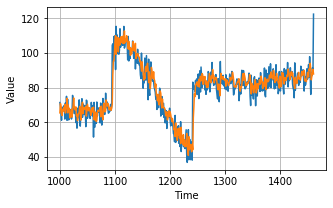

In [53]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

### Measure the Mean Absolute Error

In [54]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.169858

# Deep neural network

### Deep Neural Network Training, Tuning and Prediction

Now let's take that to the next step with a DNN to see if we can improve our model accuracy. It's not that much different from the linear regression model we saw earlier. And this is a relatively simple deep neural network that has three layers. So let's unpack it line by line.

In [55]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

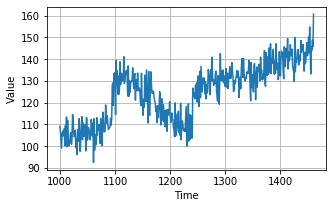

In [64]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)

In [59]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

- First we'll have to get a data set which will generate by passing in x_train data, along with the desired window size, batch size, and shuffle buffer size.
- We'll then define the model. Let's keep it **simple with three layers of 10, 10, and 1 neurons. The input shape is the size of the window and we'll activate each layer using a relu.**
- We'll then compile the model as before with a mean squared error loss function and stochastic gradient descent optimizer.
- Finally, we'll fit the model over 100 epochs, and after a few seconds of training, we'll see results that look like this. It's pretty good still.

In [60]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

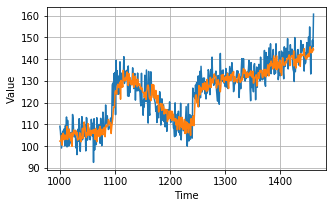

In [61]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(5, 3))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

The mean absolute error is lower than we were earlier, so it's a step in the right direction. But it's also a somewhat a step in the dark, particularly with the optimizer function.

In [62]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.65331

### Optimal Learning Rate

Wouldn't it be nice if we could pick the optimal learning rate instead of the one that we chose? We might learn more efficiently and build a better model. Now let's look at a technique for that that **uses callbacks** that you used way back in the first course.

So here's a code for the previous neural network. But I've **added a callback to tweak the learning rate** using a learning rate scheduler. You can see that code here. This will be called at the callback at the end of each epoch. What it will do is **change the learning rates to a value based on the epoch number.**

So in epoch 1, it is 1 times 10 to the -8 times 10 to the power of 1 over 20. And by the time we reach the 100 epoch, it'll be 1 times 10 to the -8 times 10 to the power of 5, and that's 100 over 20. This will happen on each callback because we set it in the callbacks parameter of modeled outfit.

In [66]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

### Plot the Loss per epoch against the Learning Rate per epoch

- The y-axis : loss for that epoch
- The x-axis : the learning rate

[1e-08, 0.001, 0, 300]

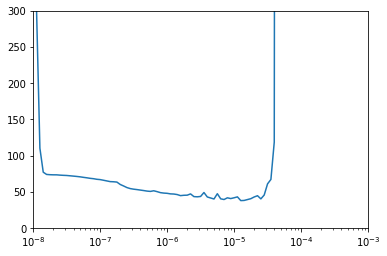

In [67]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

We can then try to pick **the lowest point of the curve** where it's still relatively stable like this, and that's right around 7 times 10 to the -6. So let's set that to be our learning rate and then we'll retrain. So here's the same neural network code, and we've updated the learning rate, so we'll also train it for a bit longer. Let's check the results after training for 500 epochs. Here's the codes to plot out the loss that was calculated during the training, and it will give us a chart like this.
Which upon first inspection looks like we're probably wasting our time training beyond maybe only 10 epochs, but it's somewhat skewed by the fact that the earlier losses were so high.

In [68]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

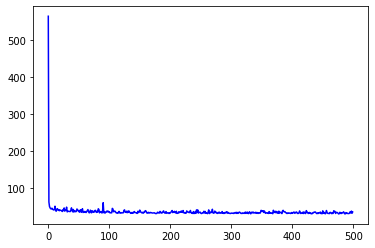

In [69]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

If we cropped them off and plot the loss for epochs after number 10 with code like this, then the chart will tell us a different story. We can see that the loss was continuing to decrease even after 500 epochs. And that shows that our network is learning very well indeed. And the mean absolute error across the results is significantly lower than earlier.

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)

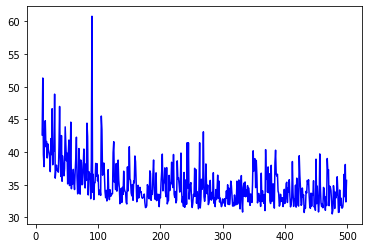

In [71]:
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

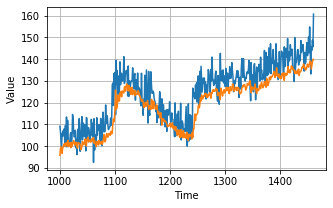

In [74]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(5, 3))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [73]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.458552